In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("talk")

In [3]:
from src.load_data import load_data

epoch_key = ("bon", 8, 4)

data = load_data(epoch_key)

Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


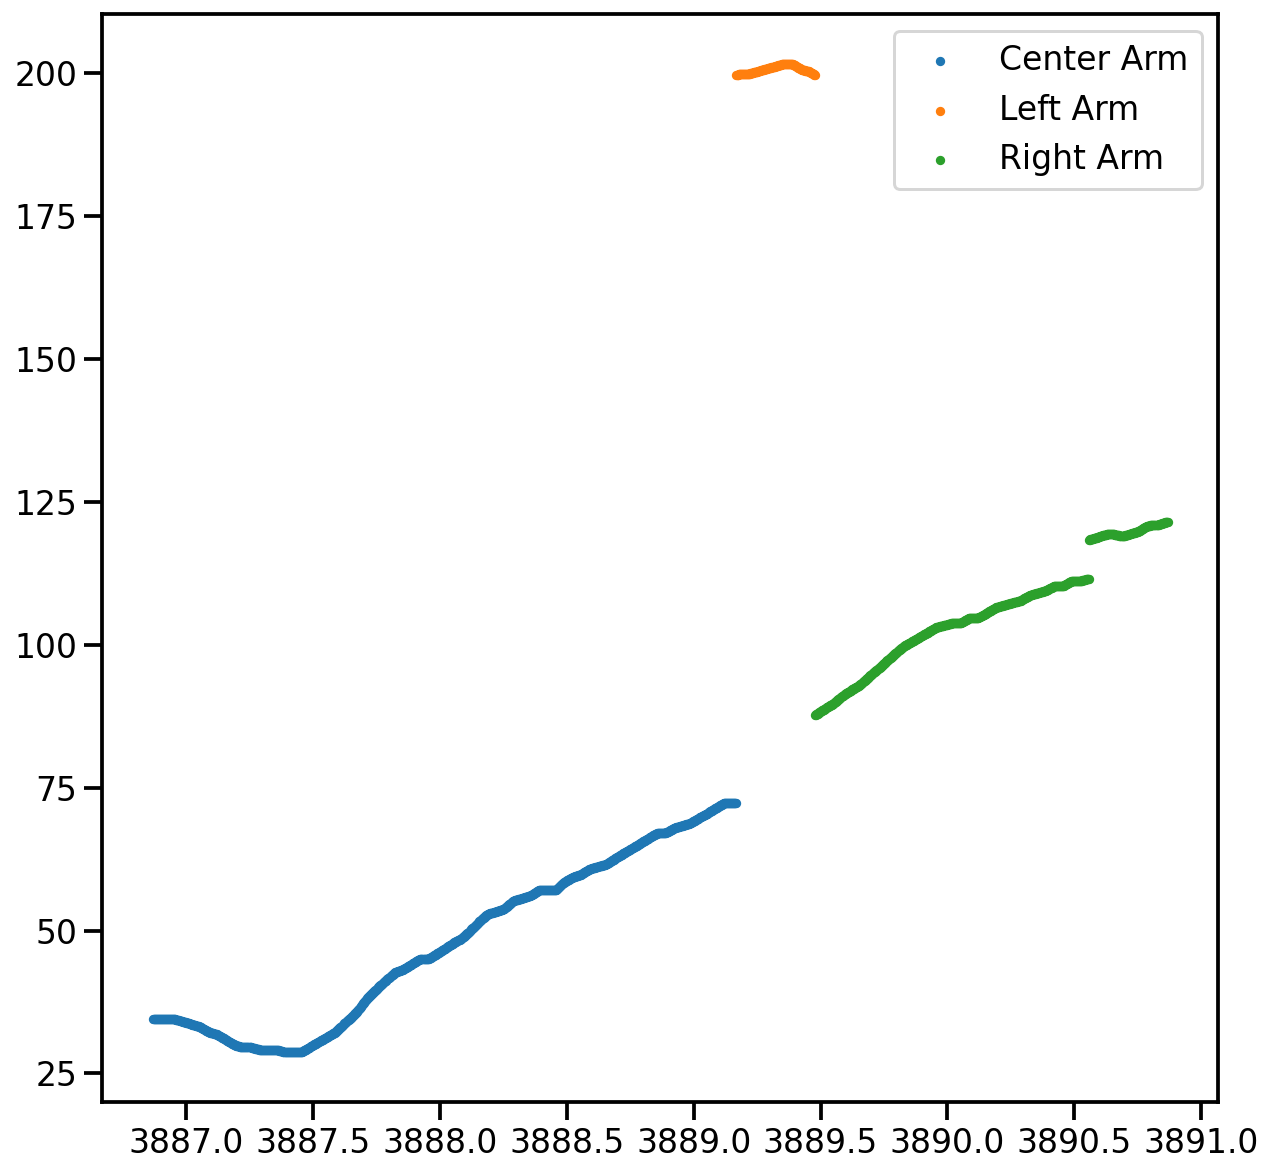

In [4]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 240.85, t.min() + 244.85)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for task, df in (
    data["position_info"].reset_index().set_index(t).loc[time_slice].groupby("arm_name")
):
    ax.scatter(
        df.index,
        df.linear_position,
        s=10,
        label=task,
    )

plt.legend()

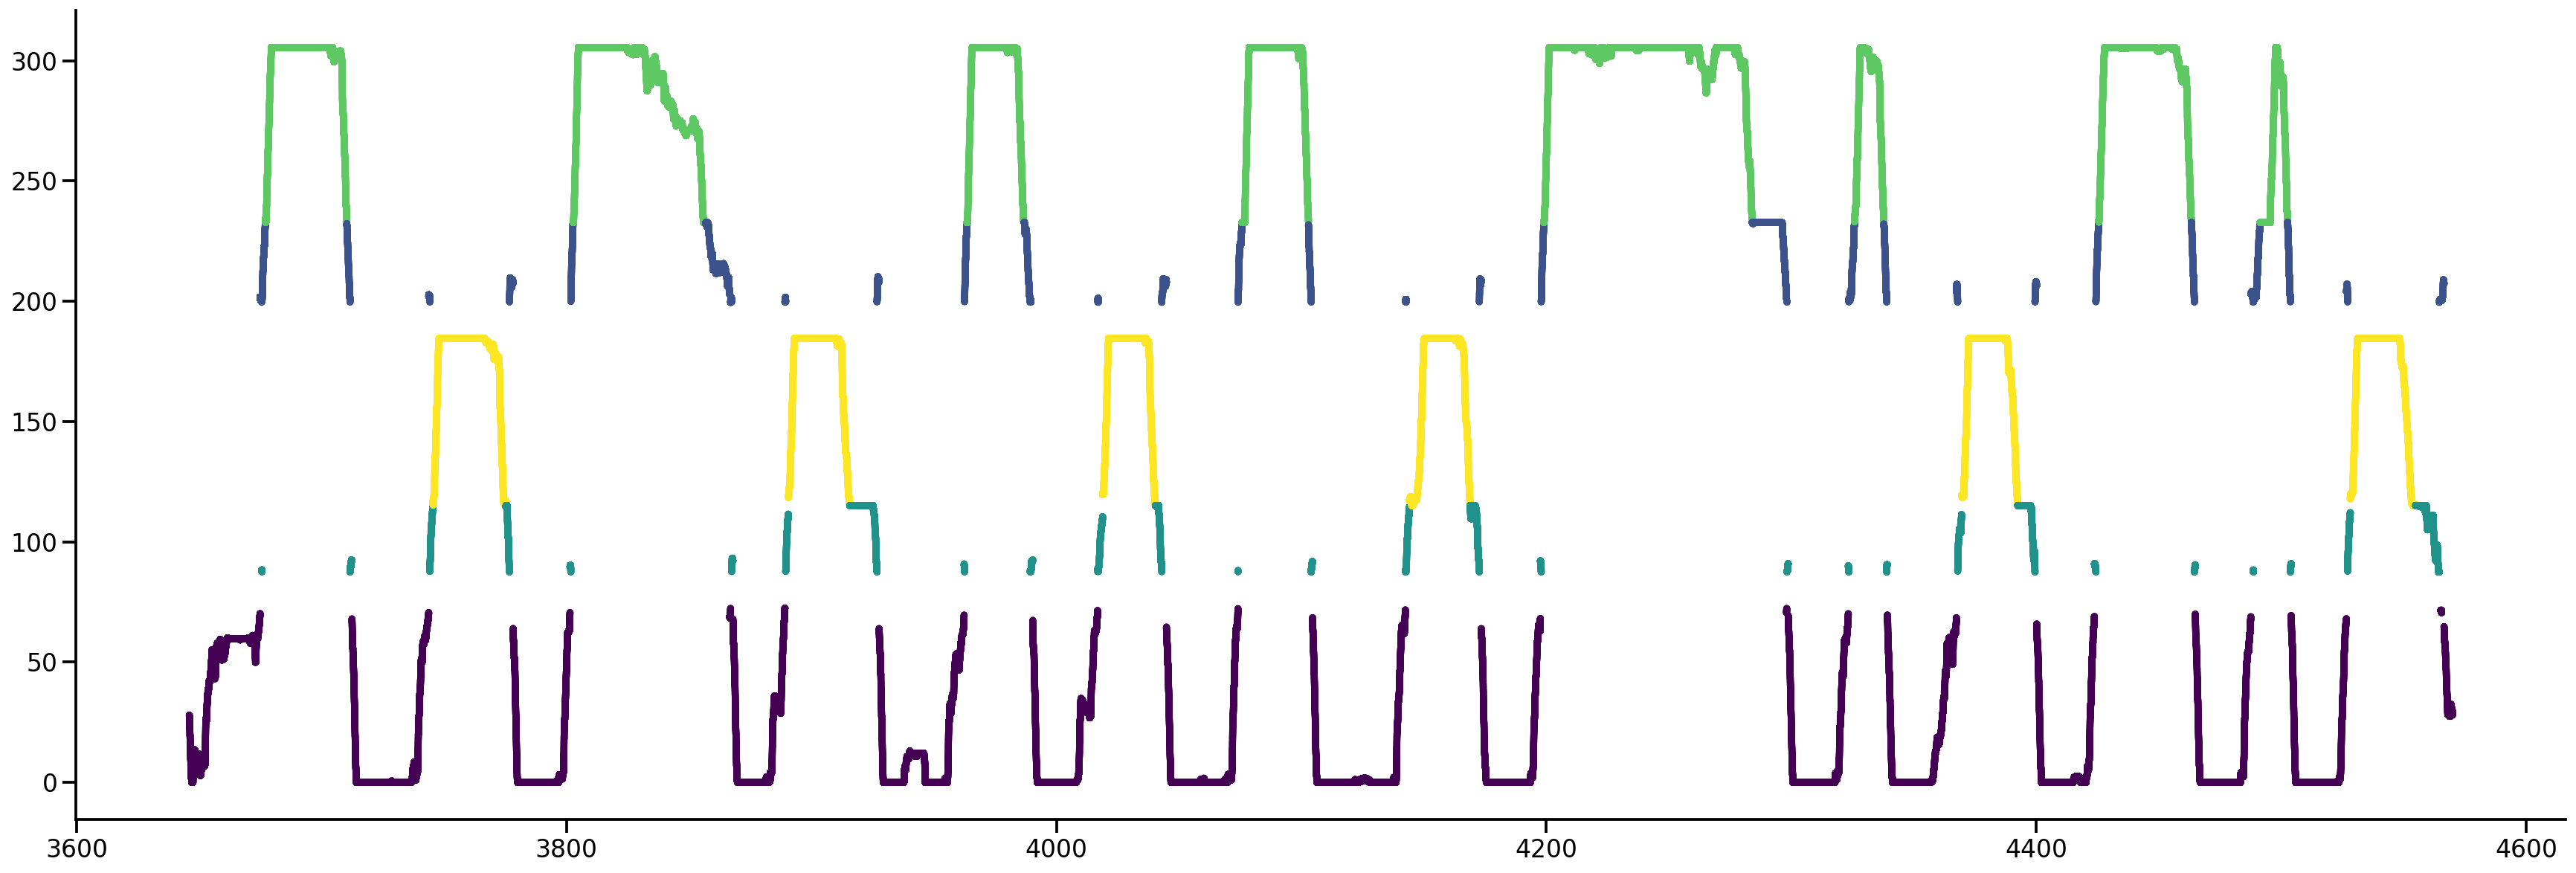

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

ax.scatter(
    data["position_info"].index / np.timedelta64(1, "s"),
    data["position_info"].linear_position,
    c=data["position_info"].track_segment_id,
    s=10,
)
sns.despine()

In [8]:
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)
from src.parameters import ANIMALS

is_running = data["position_info"].speed > 4
is_outbound = data["position_info"].task == "Outbound"

track_labels = data["position_info"].arm_name

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

Inbound
Outbound


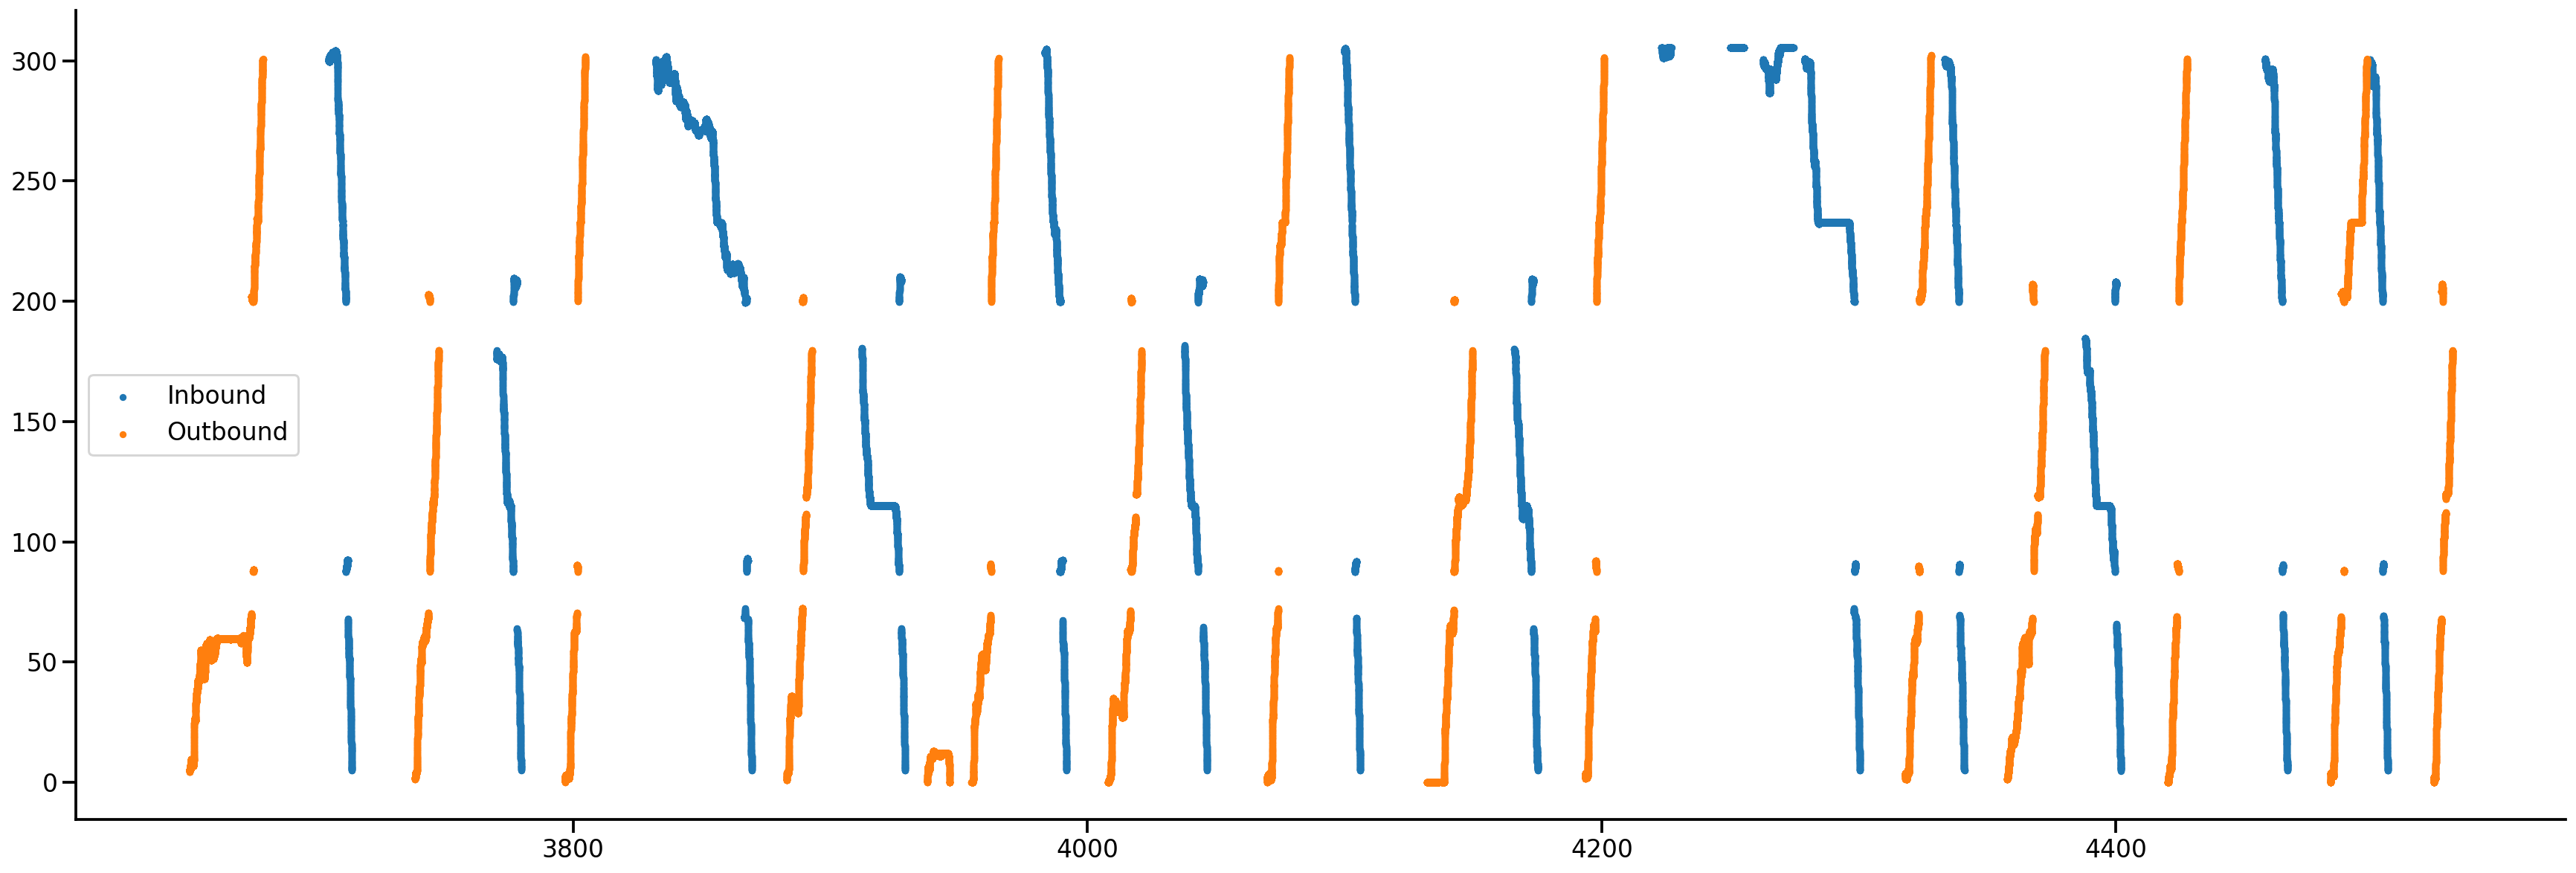

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

for task, df in data["position_info"].groupby("task"):
    print(task)
    ax.scatter(
        df.index / np.timedelta64(1, "s"),
        df.linear_position,
        s=10,
        label=task,
    )

plt.legend()
sns.despine()

Center Arm
Left Arm
Right Arm


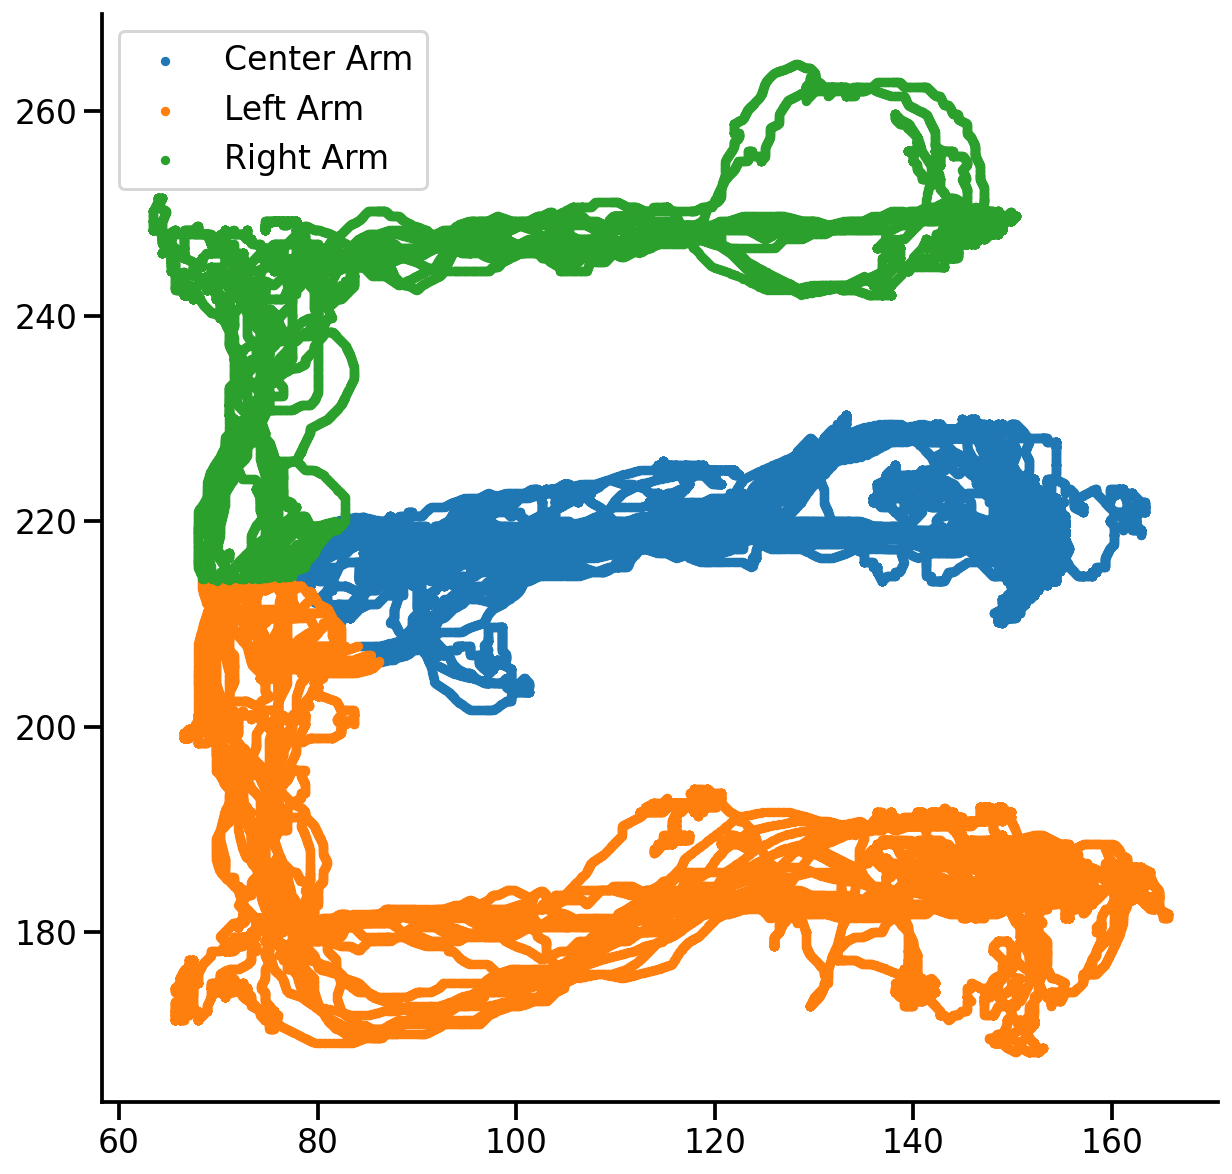

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for task, df in data["position_info"].groupby("arm_name"):
    print(task)
    ax.scatter(
        df.y_position,
        df.x_position,
        s=10,
        label=task,
    )

plt.legend()
sns.despine()

In [21]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import classifier_parameters, discrete_state_transition

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [23]:
classifier = ClusterlessClassifier(**classifier_parameters)

cv = KFold()
cv_classifier_clusterless_results = []

for fold_ind, (train, test) in tqdm(enumerate(cv.split(data["position_info"].index))):

    cv_classifier = ClusterlessClassifier(**classifier_parameters)

    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunit"].isel(time=train),
        is_training=is_running.iloc[train],
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    cv_classifier.discrete_state_transition_ = discrete_state_transition

    cv_classifier_clusterless_results.append(
        cv_classifier.predict(
            data["multiunit"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )

5it [37:37, 451.55s/it]


In [56]:
import xarray as xr

cv_classifier_clusterless_results = xr.concat(
    cv_classifier_clusterless_results, dim="time"
)


TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'str'>

In [57]:
cv_classifier_clusterless_results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_clusterless_results.nc"
)

: 

In [26]:
def plot_local_non_local_time_slice_classifier(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
):
    cmap = plt.cm.viridis
    cmap.set_bad("white", alpha=0.0)

    fig, axes = plt.subplots(
        4,
        1,
        figsize=figsize,
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [3, 1, 1, 1]},
    )

    # ax 0
    results[posterior_type].sum("state", skipna=False).sel(time=time_slice).plot(
        x="time",
        y="position",
        robust=True,
        ax=axes[0],
        cmap=cmap,
        vmin=0.0,
    )

    arm_min_max = (
        data["position_info"]
        .groupby("arm_name")
        .linear_position.aggregate(["min", "max"])
    )
    max_time = results.sel(time=time_slice).time.max() + 0.01
    axes[0].text(
        max_time,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[0].set_ylabel("Position [cm]")

    axes[0].set_title("Posterior")

    axes[0].plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="white",
        linestyle="--",
        linewidth=5,
        alpha=0.8,
    )
    axes[0].set_xlabel("")

    # ax 1
    results[posterior_type].sum("position").sel(time=time_slice).plot(
        x="time",
        hue="state",
        ax=axes[1],
    )
    axes[1].set_title("Probability")
    axes[1].set_ylabel("Probability")
    axes[1].set_xlabel("")

    # ax 2
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )

    axes[2].fill_between(
        multiunit_firing.loc[time_slice].index.values,
        multiunit_firing.loc[time_slice].values.squeeze(),
        color="black",
    )
    axes[2].set_ylabel("Firing Rate\n[spikes / s]")
    axes[2].set_title("Multiunit")

    # ax 3
    axes[3].fill_between(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[3].set_ylabel("Speed [cm / s]")
    axes[3].set_xlabel("Time [ms]")
    sns.despine()

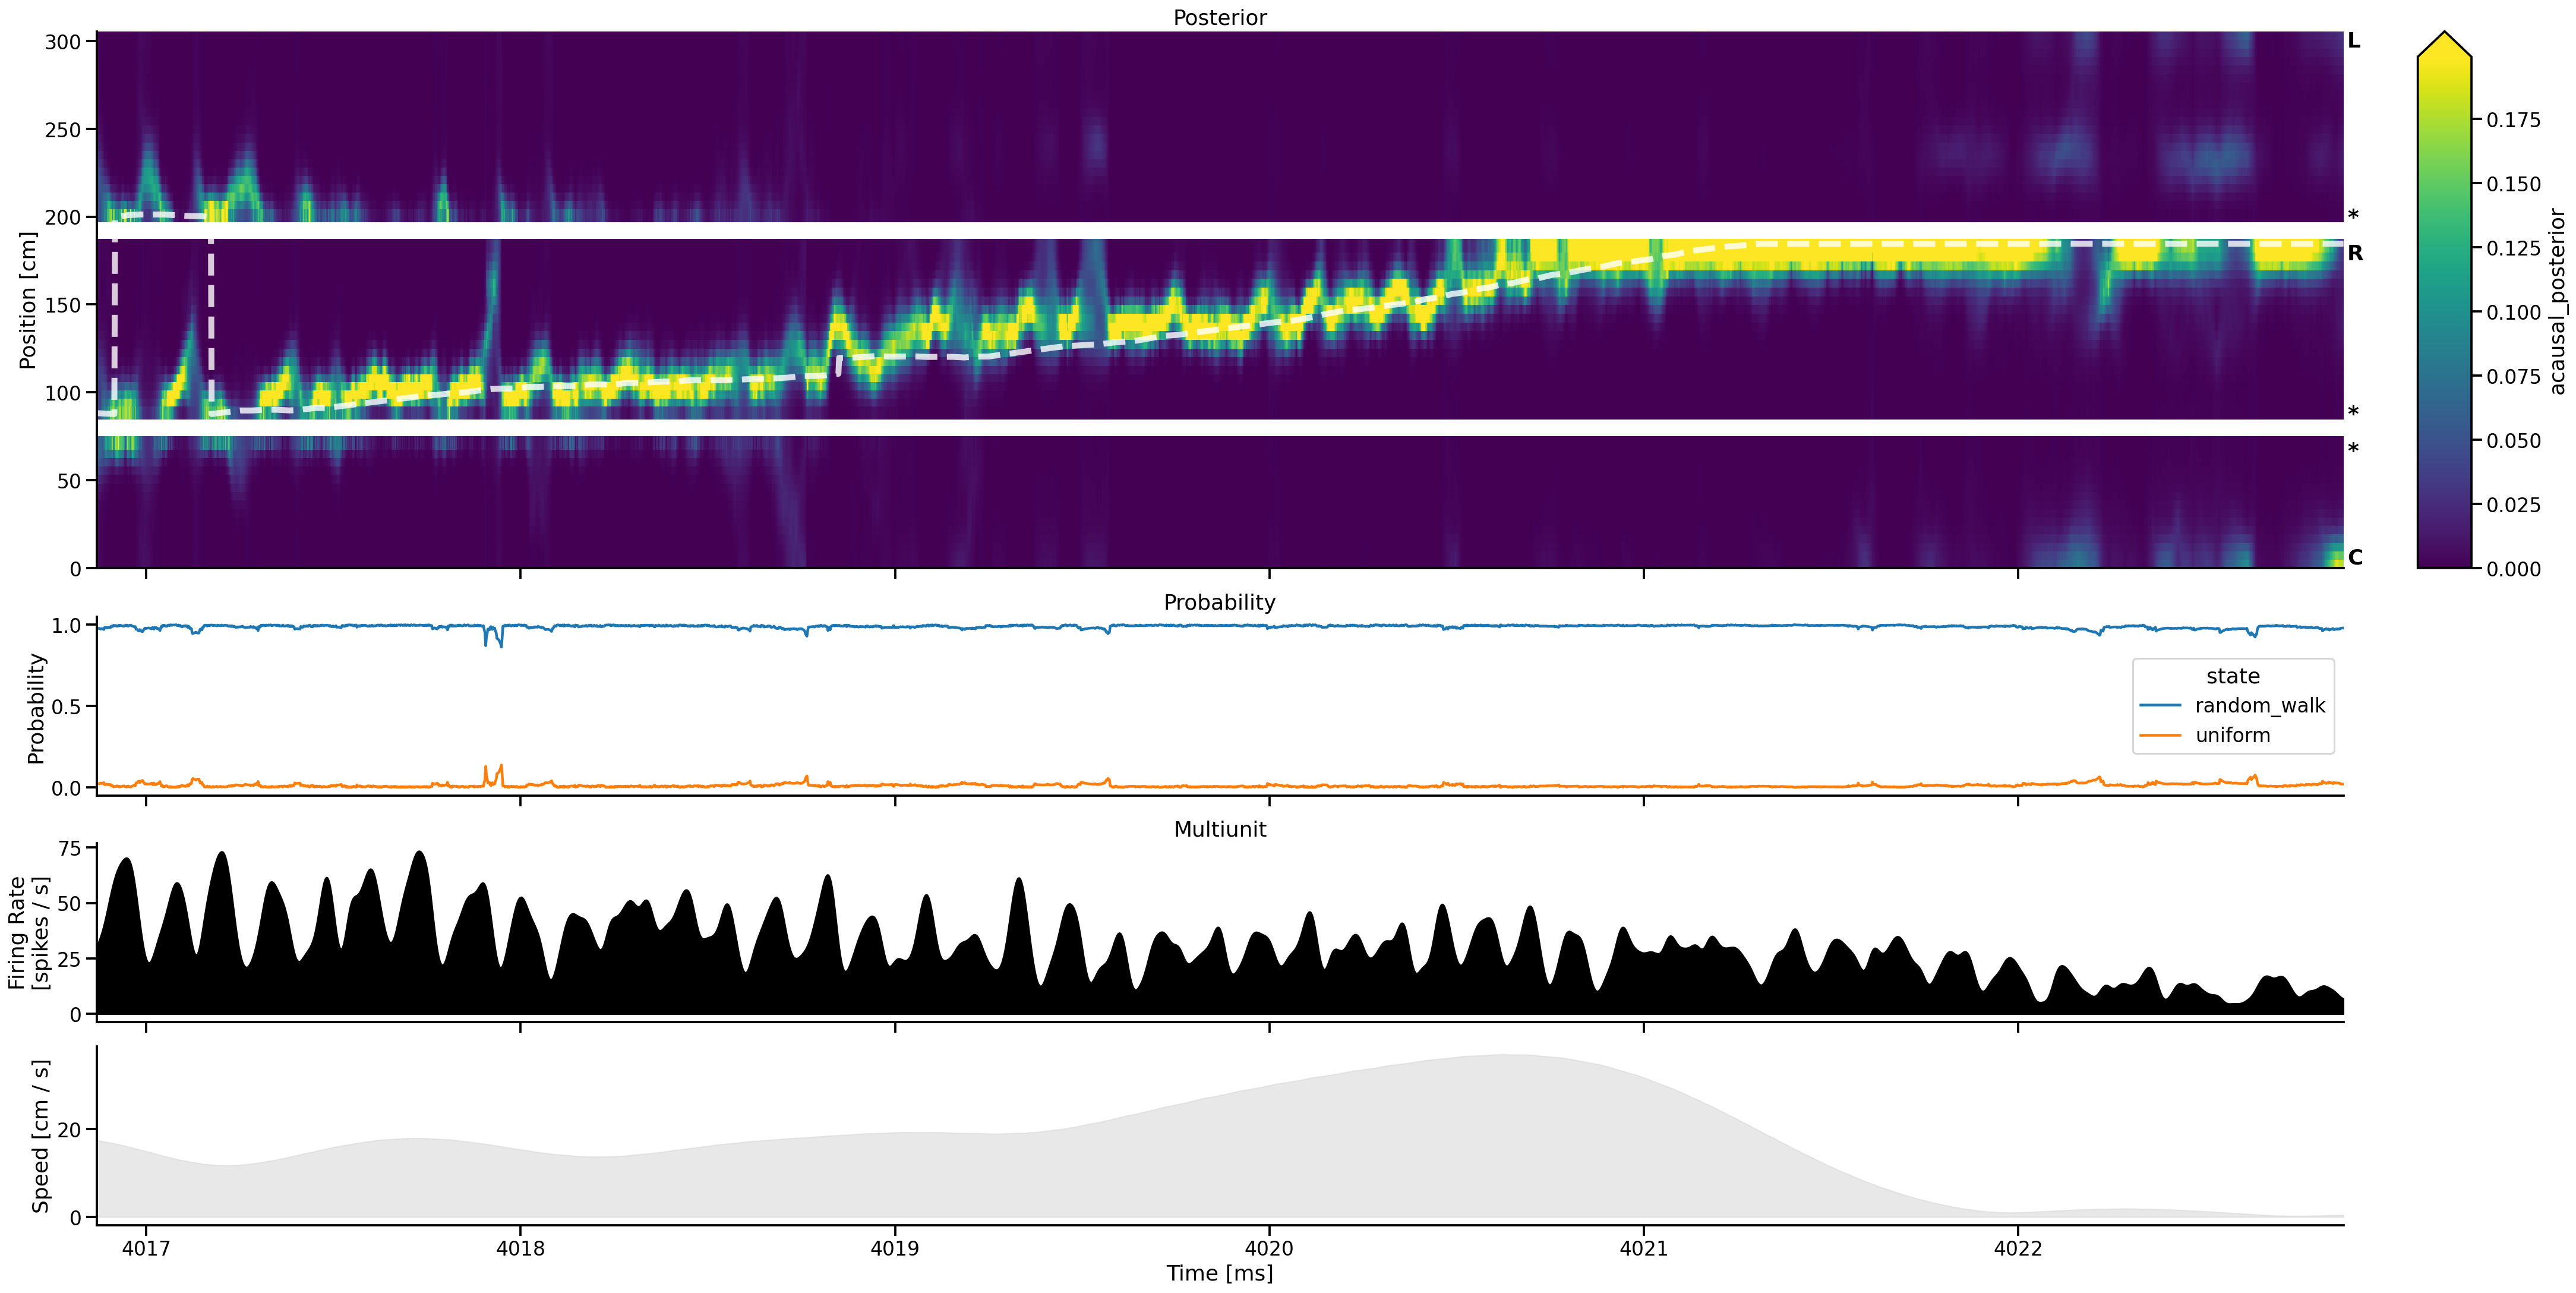

In [55]:
# extrat the time slice from the data but only is_running ones

# t = data["position_info"].index[np.where(is_running)[0]] / np.timedelta64(1, "s")
t = data["position_info"].index / np.timedelta64(1, "s")
# time_slice = slice(t.min() + 240.85, t.min() + 298.85)
time_slice = slice(t.min() + 370.85, t.min() + 376.85)
plot_local_non_local_time_slice_classifier(
    time_slice, classifier, cv_classifier_clusterless_results, data
)

In [35]:
t = data["position_info"].index[np.where(is_running)[0]] / np.timedelta64(1, "s")

In [39]:
np.where(is_running)

(array([     0,      1,      2, ..., 461586, 461587, 461588]),)

## Load classifier results and position info from processed data folder

In [6]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle

In [7]:
def bandpassfilter(data, lowcut=5, highcut=11, fs=500):
    '''
    band pass filter of the signal
    Created by Zilong, 30/08/2021
    '''
    lowcut = 5
    highcut = 11
    order = 5
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    filtereddata = signal.filtfilt(b, a, data)
    
    return filtereddata

In [8]:
def plot_thetasweeps(time_slice, results, data):
    
    '''
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice: the time slice to plot
        results: the classification results (cross-validated)
        data: the data dictionary
    Output:
        a plot with 4 subplots
    '''
    
    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=0.0)

    fig, axes = plt.subplots(6,1,figsize=(30, 25),sharex=True,constrained_layout=True,
        gridspec_kw={"height_ratios": [1, 3, 1, 1, 1, 1]},
    )
    
    #ax 0: lfp from CA3 
    ind = 0
    lfp = (data['lfps'].reset_index(drop=True).set_index(data['lfps'].index / np.timedelta64(1, "s")))

    #plot as curve, not fill
    axes[0].plot(lfp.loc[time_slice].index.values, lfp.loc[time_slice].iloc[:,ind].values.squeeze(), color="lightgrey")
    axes[0].set_ylabel("LFP")
    axes[0].set_title("LFP")

    #add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
    lfp0 = bandpassfilter(lfp.iloc[:,ind], lowcut=5, highcut=11, fs=500)
    #group the lfp0 into dataframe with time index
    lfp0 = pd.DataFrame(lfp0, index=lfp.index)
    #plot the filtered lfp
    axes[0].plot(lfp.loc[time_slice].index.values, lfp0[time_slice], color="black", linewidth=2)
    
    # ax 1
    results["acausal_posterior"].sum("state", skipna=False).sel(time=time_slice).plot(
        x="time",
        y="position",
        robust=True,
        ax=axes[1],
        cmap=cmap,
        vmin=0.0,
    )

    arm_min_max = (
        data['position_info']
        .groupby("arm_name")
        .linear_position.aggregate(["min", "max"])
    )
    max_time = results.sel(time=time_slice).time.max() + 0.01
    axes[1].text(
        max_time,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[1].set_ylabel("Position [cm]")

    axes[1].set_title("Posterior")

    axes[1].plot(
        data['position_info'].reset_index().set_index(t).loc[time_slice].index,
        data['position_info'].reset_index().set_index(t).loc[time_slice].linear_position,
        color="white",
        linestyle="--",
        linewidth=5,
        alpha=0.8,
    )
    axes[1].set_xlabel("")
    
    # ax 2
    results.mental_distance_from_actual_position.sel(time=time_slice).plot(
        x="time",
        ax=axes[2],
        color="black",
        linewidth=2
    )

    # ax 3
    results["acausal_posterior"].sum("position").sel(time=time_slice).plot(
        x="time",
        hue="state",
        ax=axes[3],
        linewidth=2
    )
    axes[3].set_title("Probability")
    axes[3].set_ylabel("Probability")
    axes[3].set_xlabel("")

    # ax 4
    multiunit_firing = (
        data['multiunit_firing_rate'].reset_index(drop=True).set_index(data['multiunit_firing_rate'].index / np.timedelta64(1, "s"))
    )

    axes[4].fill_between(
        multiunit_firing.loc[time_slice].index.values,
        multiunit_firing.loc[time_slice].values.squeeze(),
        color="black",
    )
    axes[4].set_ylabel("Firing Rate\n[spikes / s]")
    axes[4].set_title("Multiunit")

    # ax 5
    axes[5].fill_between(
        data['position_info'].reset_index().set_index(t).loc[time_slice].index,
        data['position_info'].reset_index().set_index(t).loc[time_slice].speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[5].set_ylabel("Speed [cm / s]")
    axes[5].set_xlabel("Time [ms]")
    sns.despine()

In [23]:
datafolder = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories'

#load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(os.path.join(datafolder, 'bon_03_04_cv_classifier_clusterless_results.nc'))

#load the data with pickle
with open(os.path.join(datafolder, 'bon_03_04_data.pkl'), 'rb') as f:
    data = pickle.load(f)

#get time slice
t = data['position_info'].index / np.timedelta64(1, "s")


/home/zilong/anaconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  app.launch_new_instance()


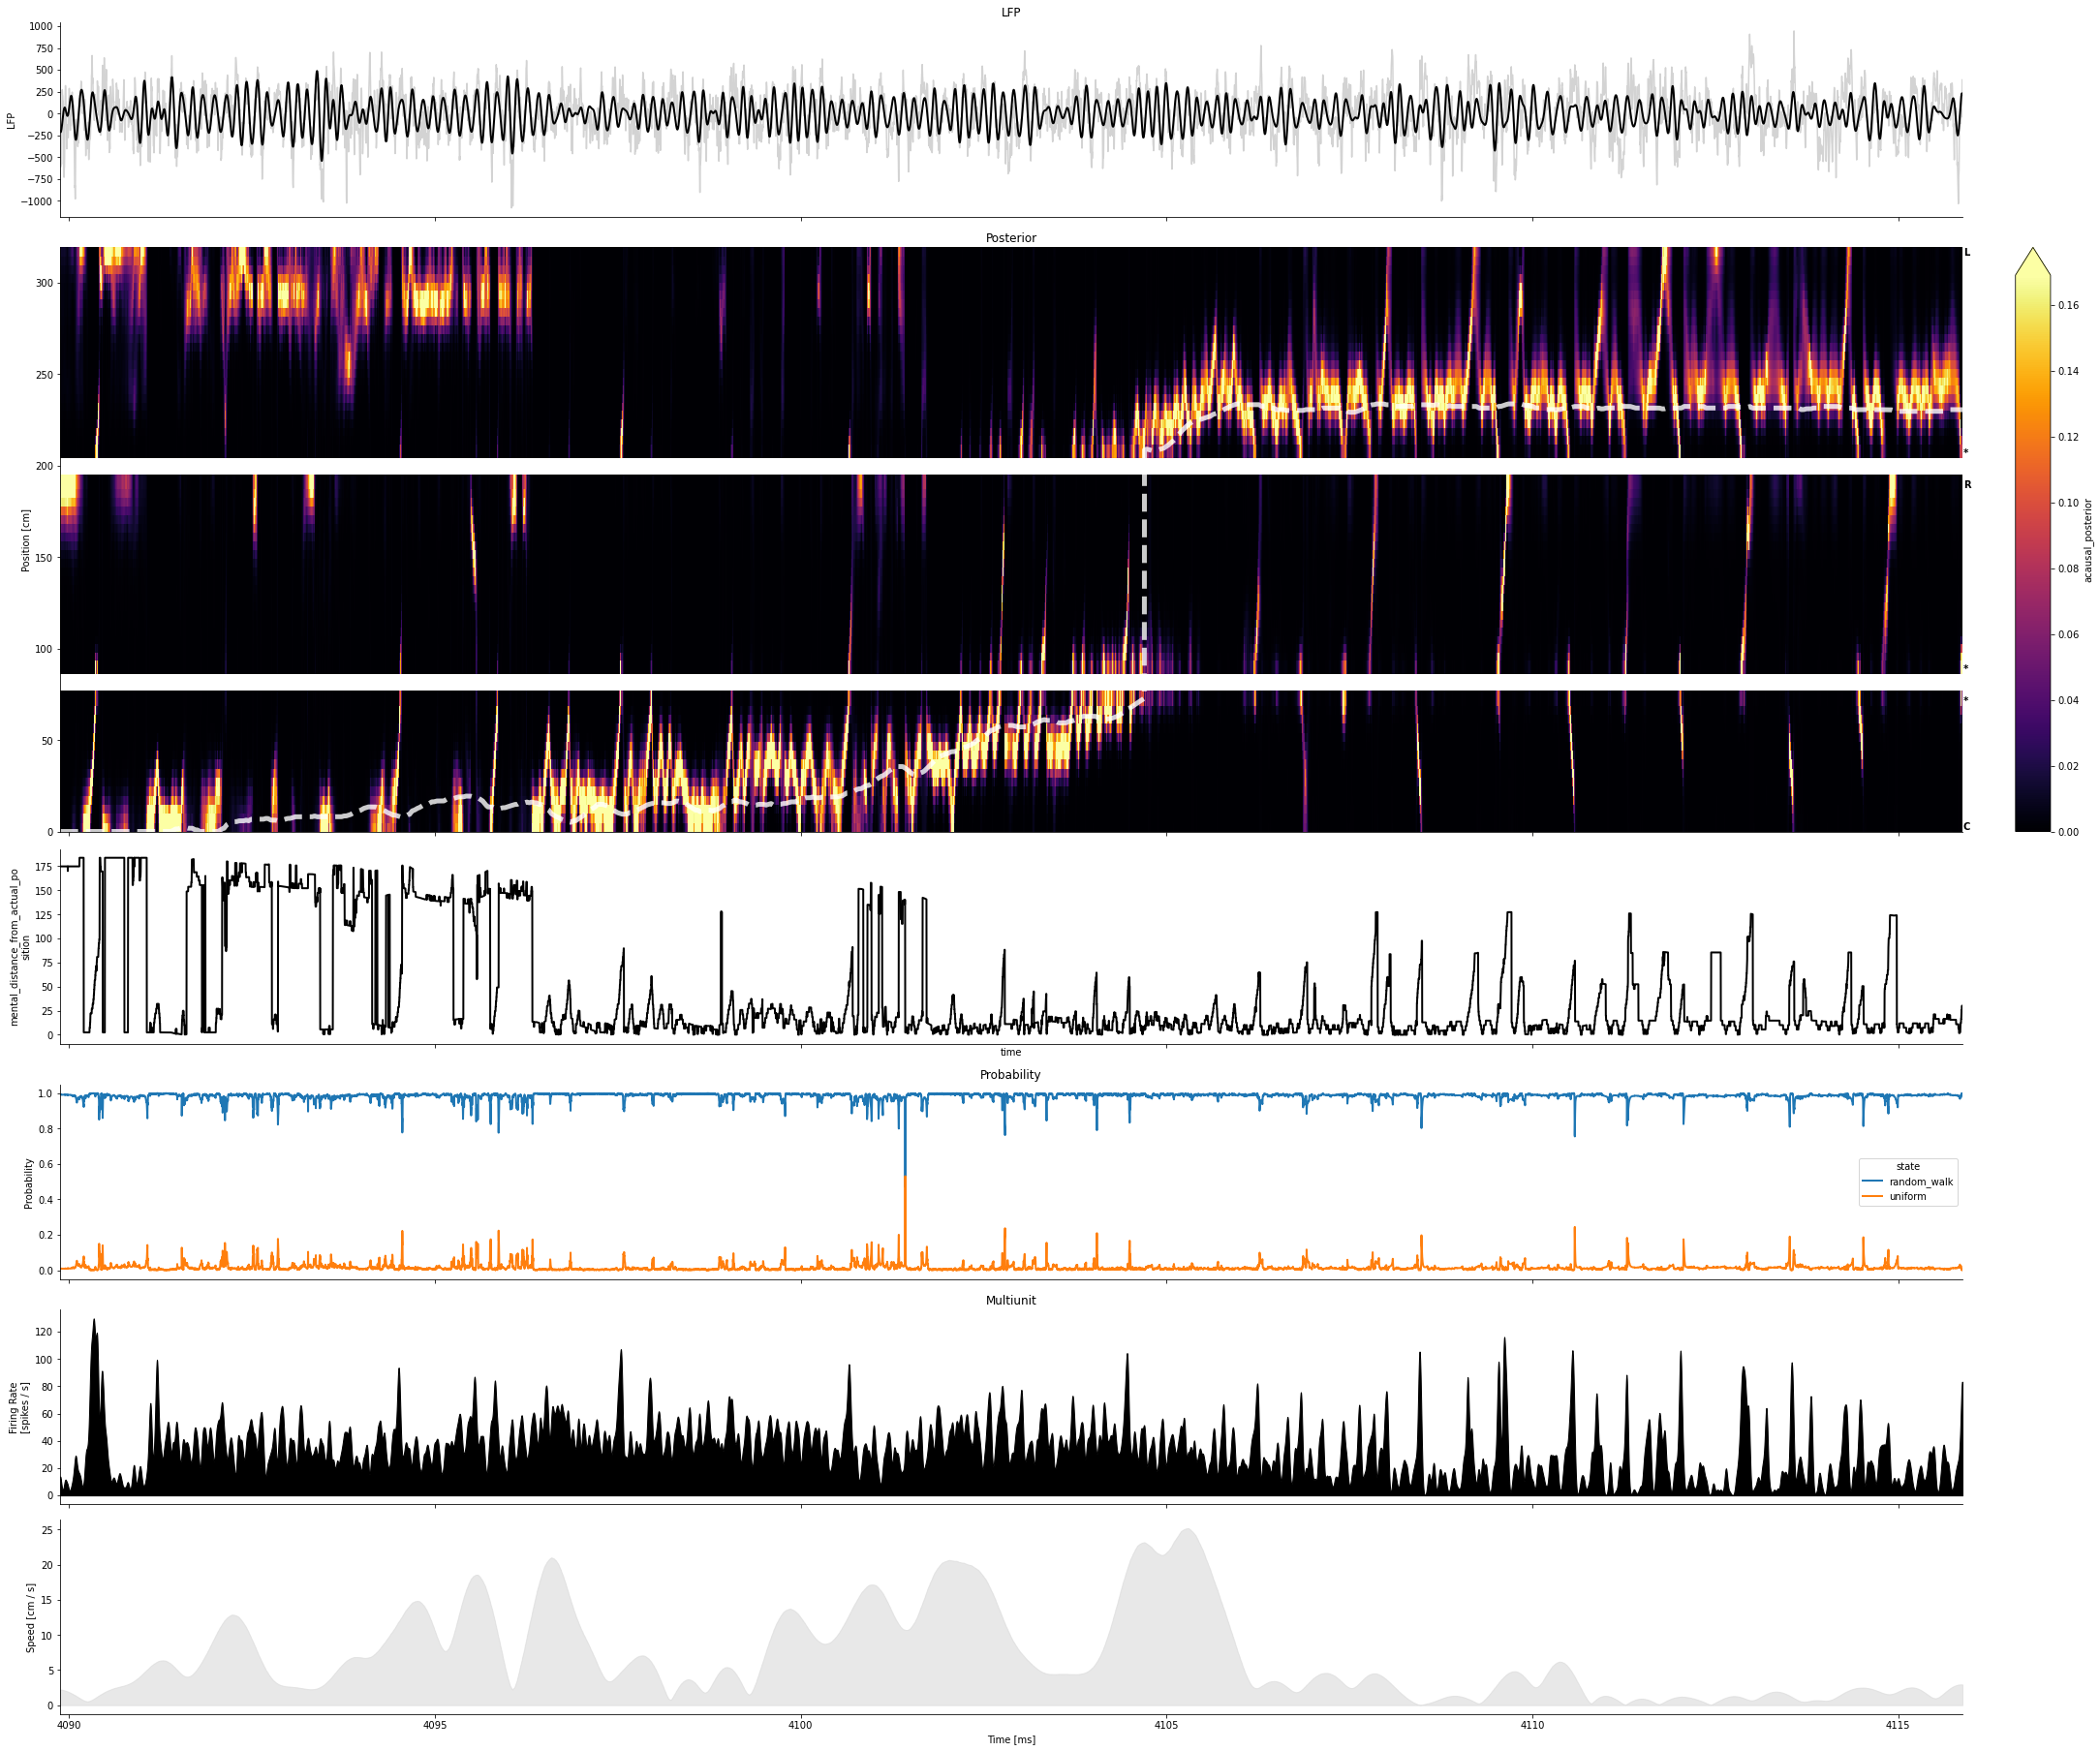

In [10]:
time_slice = slice(t.min() + 360.85, t.min() + 386.85)
plot_thetasweeps(time_slice, cv_classifier_clusterless_results, data)

/home/zilong/anaconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  app.launch_new_instance()


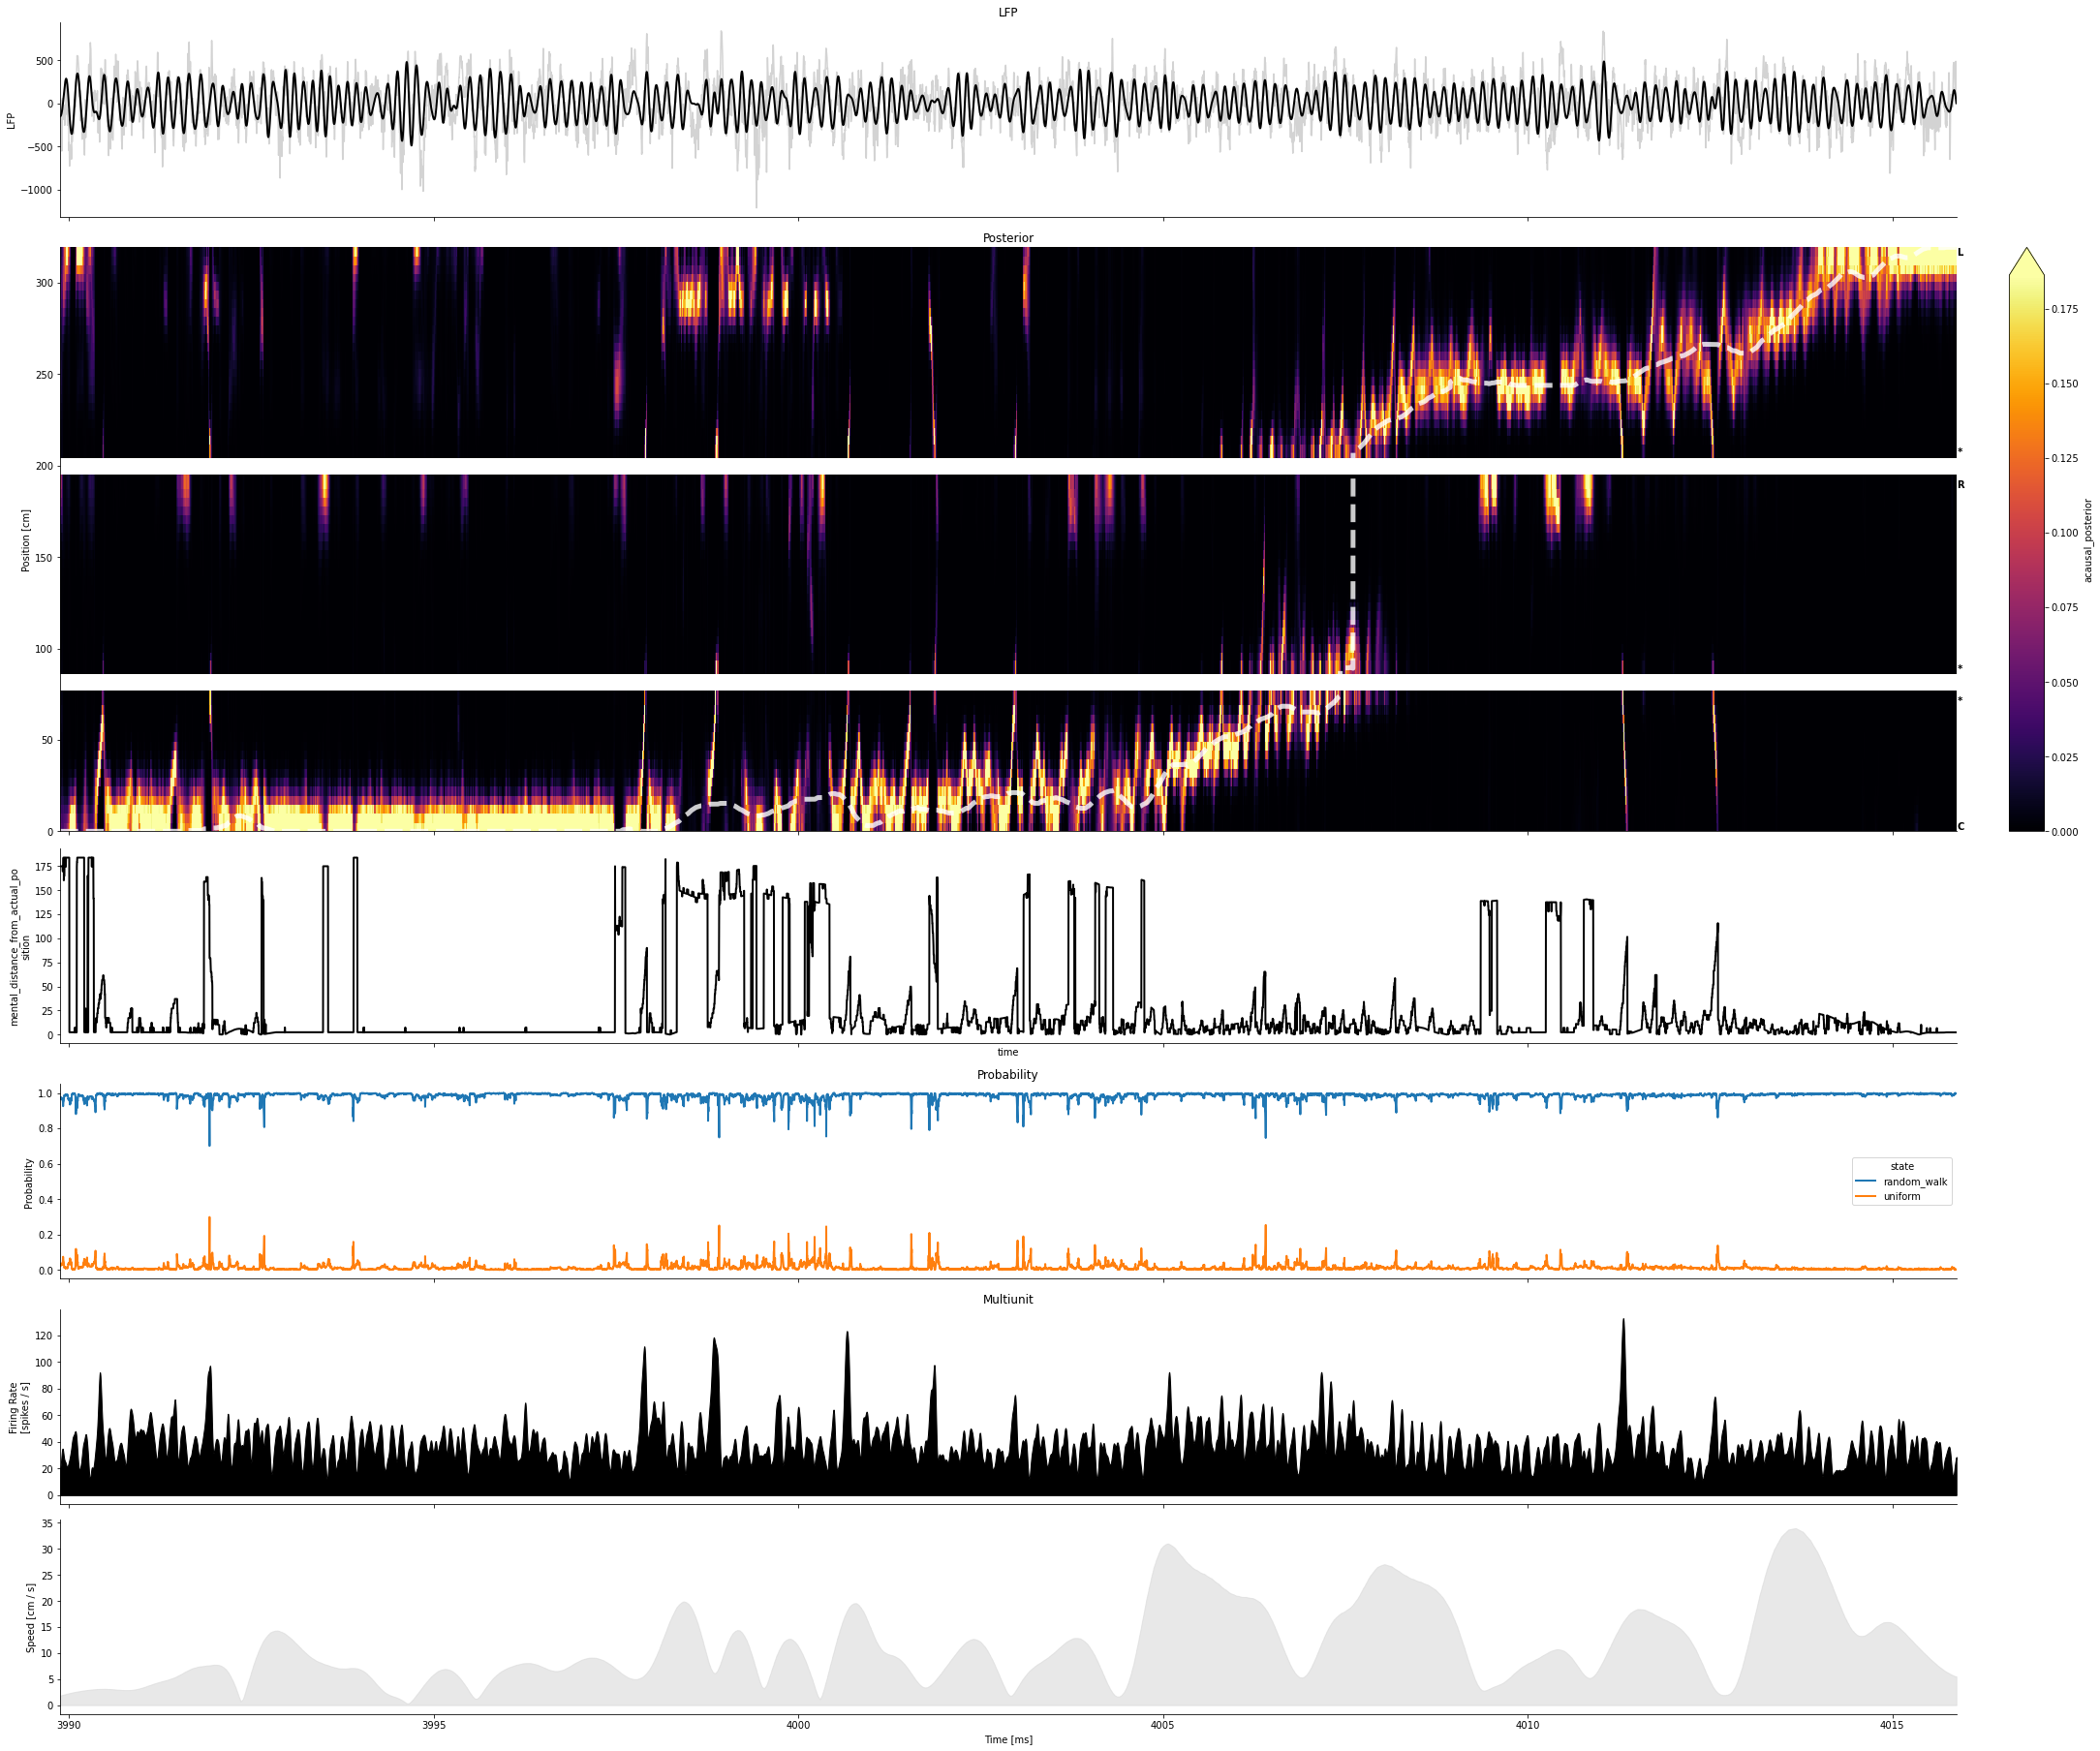

In [11]:
time_slice = slice(t.min() + 260.85, t.min() + 286.85)
plot_thetasweeps(time_slice, cv_classifier_clusterless_results, data)

/home/zilong/anaconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  app.launch_new_instance()


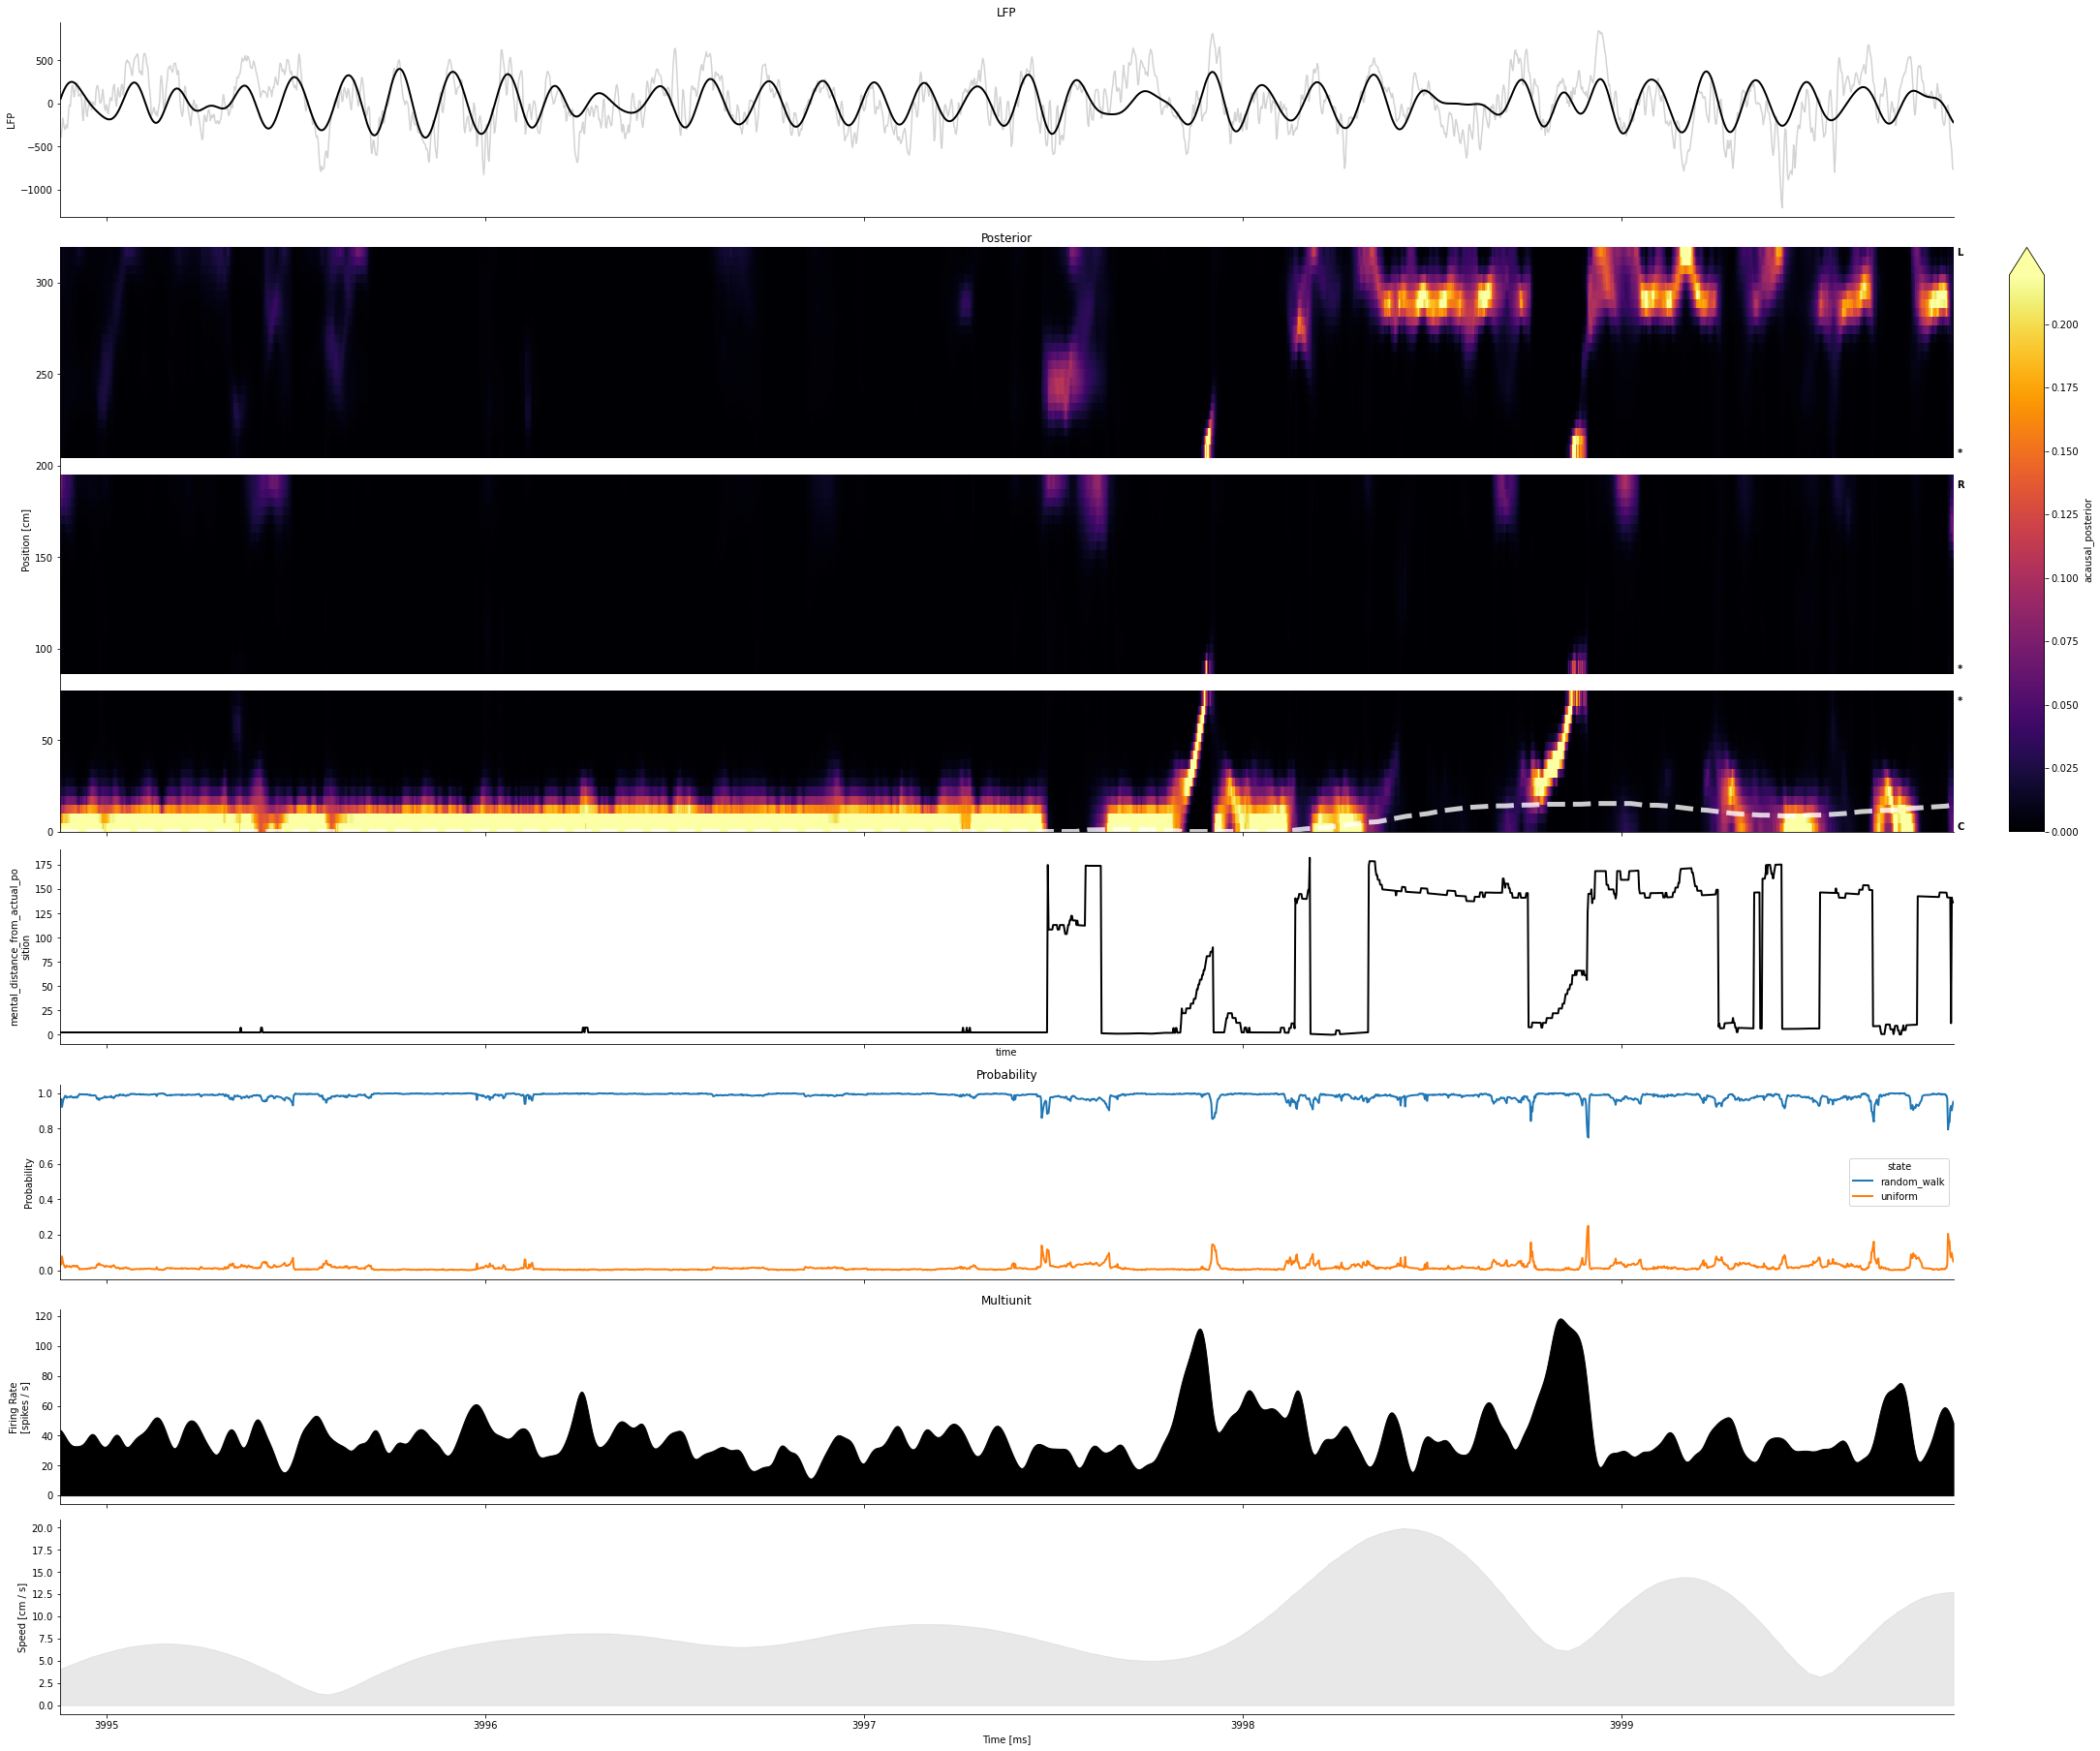

In [12]:
time_slice = slice(t.min() + 265.85, t.min() + 270.85)
plot_thetasweeps(time_slice, cv_classifier_clusterless_results, data)

In [5]:
ind = 0
lfp = (data['lfps'].reset_index(drop=True).set_index(data['lfps'].index / np.timedelta64(1, "s")))

#add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
lfp0 = bandpassfilter(lfp.iloc[:,ind], lowcut=5, highcut=11, fs=500)
#group the lfp0 into dataframe with time index
lfp0 = pd.DataFrame(lfp0, index=lfp.index)
#to numpy array
lfp0 = lfp0.to_numpy()
#zscore the lfp0
lfp0 = (lfp0 - np.mean(lfp0)) / np.std(lfp0)

mua = data['multiunit_firing_rate'].reset_index(drop=True).set_index(data['multiunit_firing_rate'].index / np.timedelta64(1, "s"))
#to numpy array
mua = mua.to_numpy()
#zscore the mua
mua = (mua - np.mean(mua)) / np.std(mua)


#for lfp0 and mua, I want to check if the two signals are anti-phase correlated

from scipy.signal import hilbert

analytic_signal1 = hilbert(lfp0[11000:12000])
analytic_signal2 = hilbert(mua[11000:12000])

#calculate instantaneous phase
phase1 = np.angle(analytic_signal1)
phase2 = np.angle(analytic_signal2)

#compute the phase difference
phase_diff = np.angle(np.exp(1j*(phase1-phase2)))

# Calculate the mean phase difference
mean_phase_diff = np.mean(phase_diff)

print("phase difference between lfp and mua is: ", mean_phase_diff)

NameError: name 'data' is not defined

In [81]:
phase1

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3.14159265],
       [-3

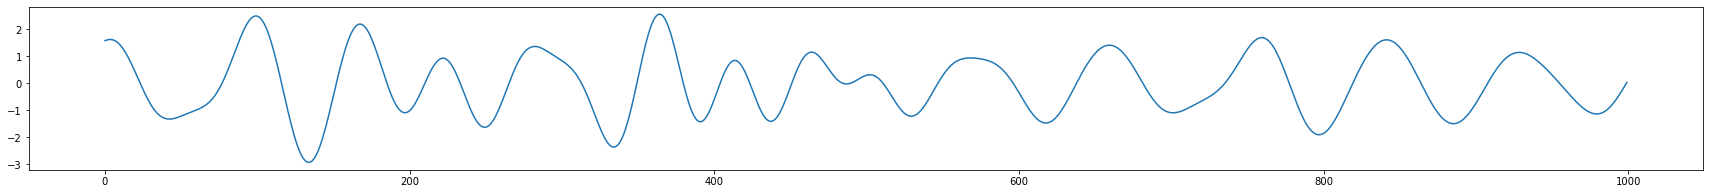

In [79]:
#plot phase_diff across time
plt.figure(figsize=(30,3));plt.plot(lfp0[11000:12000])

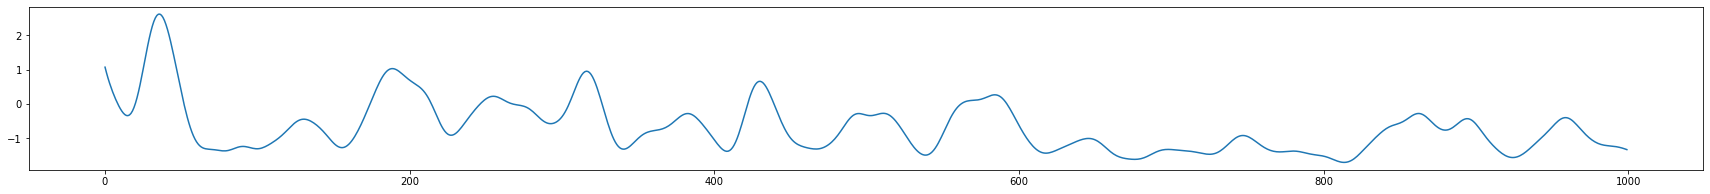

In [80]:
plt.figure(figsize=(30,3));plt.plot(mua[10000:11000])

In [76]:
t = np.linspace(0, 2*np.pi, 100)
signal1 = np.sin(t)+1

analytic_signal1 = hilbert(signal1)

phase1 = np.angle(analytic_signal1)

phase1

array([-0.74797087, -0.73662553, -0.70409099, -0.67850705, -0.64609192,
       -0.6177955 , -0.58546733, -0.55604648, -0.52378665, -0.49375843,
       -0.46155473, -0.43114913, -0.39899294, -0.36833121, -0.33621616,
       -0.30536953, -0.27329072, -0.24230434, -0.21025791, -0.17916202,
       -0.14714488, -0.11596062, -0.08397025, -0.05271289, -0.02074721,
        0.0105719 ,  0.04251462,  0.07388686,  0.10580807,  0.13722682,
        0.16912772,  0.20058779,  0.23246941,  0.26396669,  0.29582989,
        0.32736113,  0.35920663,  0.39076924,  0.42259764,  0.45418955,
        0.48600134,  0.51762094,  0.54941652,  0.58106256,  0.61284224,
        0.64451378,  0.67627778,  0.70797418,  0.73972266,  0.77144352,
        0.80317655,  0.83492173,  0.86663931,  0.89840889,  0.93011096,
        0.96190525,  0.99359167,  1.02541122,  1.05708178,  1.08892739,
        1.12058178,  1.1524545 ,  1.18409232,  1.21599344,  1.24761417,
        1.27954517,  1.31114809,  1.34311039,  1.37469435,  1.40

## Get the mean theta sweep amplitude


In [81]:
datafolder = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories'

#load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(os.path.join(datafolder, 'bon_05_02_cv_classifier_clusterless_results.nc'))

#load the data with pickle
with open(os.path.join(datafolder, 'bon_05_02_data.pkl'), 'rb') as f:
    data = pickle.load(f)

#get time slice
t = data['position_info'].index / np.timedelta64(1, "s")

In [82]:
#extract speed from data and threshold it with 10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 0) & (speed < 4)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(48.53226815)

In [83]:
#extract speed from data and threshold it with 10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 4) & (speed < 8)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(18.52399689)

In [84]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 8) & (speed < 12)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(18.91138412)

In [85]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 12) & (speed < 16)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(15.49301687)

In [86]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 16) & (speed < 20)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(14.08967367)

In [87]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 20) & (speed < 24)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(11.26420886)

In [88]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 24) & (speed < 28)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(10.39564268)

In [89]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 28) & (speed < 32)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(10.03507926)

In [90]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 32) & (speed < 36)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(9.80961358)

In [91]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 36) & (speed < 40)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(10.09864676)

In [92]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 15) & (speed < 25)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(12.83900351)

In [58]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 15) & (speed < 35)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(12.30166584)

In [115]:
#extract speed from data and threshold it between 4-10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 25) & (speed < 45)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(10.92558394)